In [1]:
#this is a testing file for various aspects of the project research
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt

In [2]:
def testBaseline(df, threshold): 
   
    df['alarm'] = df['rolling_std'] > threshold

    #get flags (only alarms where they are the first occurence in a group of alarms)
    flags = pd.Series(False, index=df.index)
    for i in range(1, len(df['alarm'])):
        flags.iloc[i] = df['alarm'].iloc[i] and not df['alarm'].iloc[i-1]
    df['flags'] = flags

    #get false alarms (defined as: flags where the vol drops below 90% of threshold within next 30 min)
    falseAlarms = pd.Series(False, index = df.index)
    for i in range(1,len(df['alarm']) - 30):
        if df['flags'].iloc[i]:
            isFalse = False #isFalse will be true for false alarms
            for j in range(30):
                if  (i + j) < len(df['rolling_std']):
                    if df['rolling_std'].iloc[i+j] < 0.9*threshold:
                        isFalse = True
                        break
            falseAlarms.iloc[i] = isFalse
        else: falseAlarms.iloc[i] = False
    df['falseAlarm'] = falseAlarms
    alarmRate = df['alarm'].sum()/len(df['alarm'])
    return df['falseAlarm'].sum()/df['flags'].sum() if (df['flags'].sum() != 0) else -1


minimum FAR 0.0
minimum FAR 0.15384615384615385
minimum FAR 0.0
minimum FAR 0.0


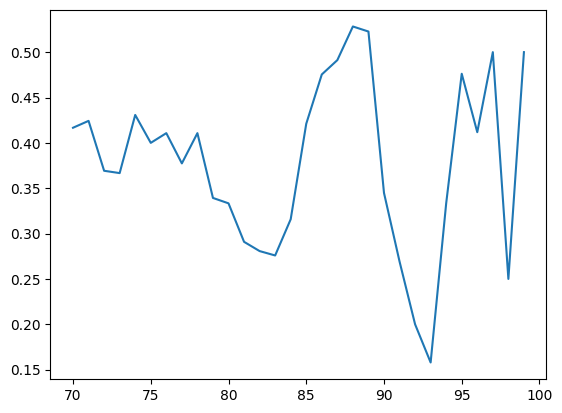

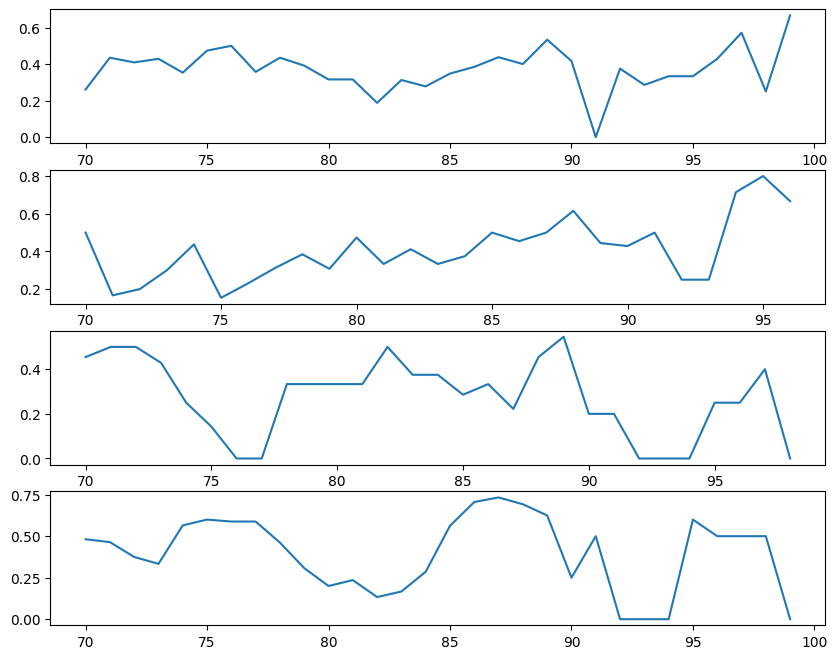

93rd percentile std: 0.000774924327868597


In [3]:
#script to test various threshold values and identify false alarms
# Loading data from CSV (SPY_Datafull.csv)
dataPath = r"C:\Users\samps\OneDrive\Documents\GitHub\Intraday-Volatility-Monitor\SPY_Datafull.csv"
df = pd.read_csv(dataPath, parse_dates=['timestamp']) # convert to Python datetime objects to sort chronologically
df = df.sort_values('timestamp')
df = df.reset_index(drop=True) # discard old index
df['returns'] = df['price'].pct_change()
df['rolling_std'] = df['returns'].rolling(window=30, min_periods=30).std() # min_periods=30 to compute only after 30 values


#print the quantile used as threshold vs F.A.R.
FalseAlarmRate = pd.DataFrame({
    "Q":   range(70,100)
})

for i in range (70,100):
    th = df['rolling_std'].quantile(0.01*i) #tweak for each trial
    FalseAlarmRate.loc[(i-70), 'FAR'] = testBaseline(df, th)
   

plt.plot(FalseAlarmRate['Q'], FalseAlarmRate['FAR'])

#split the data in to 4 chunks and print the same data on each chunk
size = len(df['rolling_std'])
df1 = df.iloc[0:math.floor(size/4)].copy()
df2 = df.iloc[math.floor(size/4):math.floor(size/2)].copy()
df3 = df.iloc[math.floor(size/2):math.floor(3*size/4)].copy()
df4 = df.iloc[math.floor(3*size/4):math.floor(size)].copy()
dataFrames = [df1, df2, df3, df4]

fAlarms = pd.DataFrame({'Q': range(70,100)})
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

count = 1

for dataFrame in dataFrames:
    for i in range (70,100):
        th = df['rolling_std'].quantile(0.01*i) #tweak for each trial
        fAlarms.loc[(i-70), 'FAR' + str(count)] = testBaseline(dataFrame, th)

    fAlarms['FAR' + str(count)] = fAlarms['FAR' + str(count)].replace(-1, np.nan)
    print( "minimum FAR " + str(fAlarms['FAR' + str(count)].min()) )
    axes[count-1].plot(fAlarms['Q'], fAlarms['FAR' + str(count)] )
    count += 1

plt.show()
print("93rd percentile std: " + str(df['rolling_std'].quantile(0.93)))



In [4]:
#random testing script
testdf = pd.DataFrame()
numSeries = pd.Series()
for i in range(0,10):
    numSeries[i] = i +2
testdf['nums'] = numSeries
testdf['bool'] = testdf['nums'] > 5
testdf.head(10)

,nums,bool
0,2,False
1,3,False
2,4,False
3,5,False
4,6,True
5,7,True
6,8,True
7,9,True
8,10,True
9,11,True


In [5]:
df = pd.read_csv('test_prices.csv', nrows=0)
print(df.columns.tolist())

['timestamp', 'symbol', 'price']


In [20]:
!"{sys.executable}" -m pip install --upgrade pip
!"{sys.executable}" -m pip install scipy

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 32.5 MB/s  0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.3
    Uninstalling pip-25.3:
      Successfully uninstalled pip-25.3
   ---------------------------------------- 0.0/36.3 MB ? eta -:--:--
   ----------- ---------------------------- 10.5/36.3 MB 59.8 MB/s eta 0:00:01
   ------------------------------ --------- 28.0/36.3 MB 71.2 MB/s eta 0:00:01
   ---------------------------------------- 36.3/36.3 MB 59.2 MB/s  0:00:00


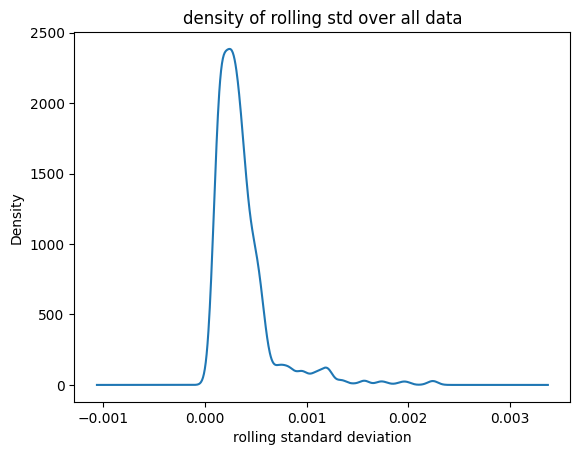

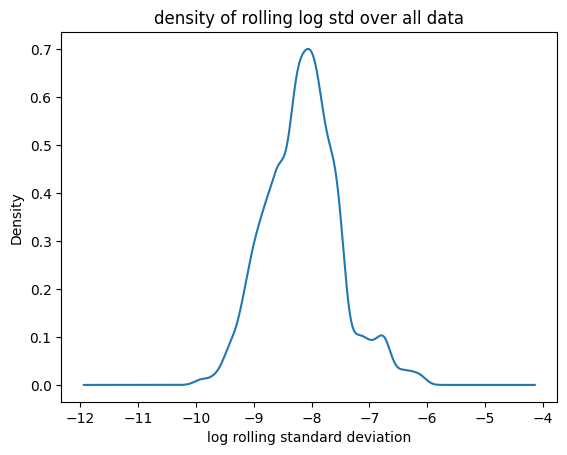

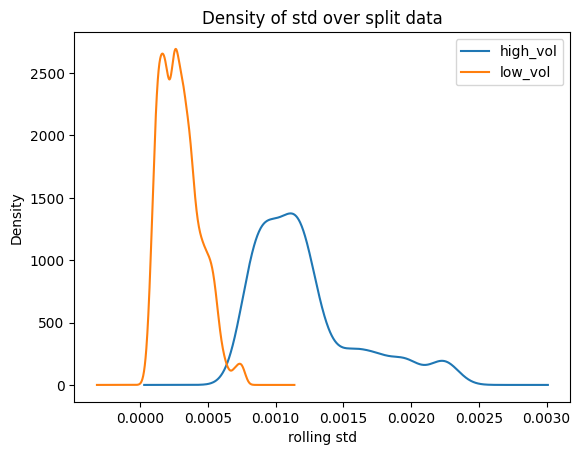

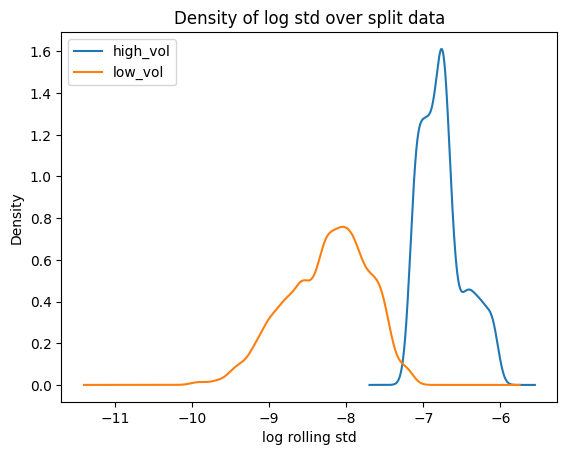

In [30]:
#plot volitility\

dataPath = r"C:\Users\samps\OneDrive\Documents\GitHub\Intraday-Volatility-Monitor\SPY_Datafull.csv"
df1 = pd.read_csv(dataPath, parse_dates=['timestamp']) # convert to Python datetime objects to sort chronologically
df1 = df1.sort_values('timestamp')
df1 = df1.reset_index(drop=True) # discard old index
df1['returns'] = df1['price'].pct_change()
df1['rolling_std'] = df1['returns'].rolling(window=30, min_periods=30).std()
df1['log_std']= np.log(df1['rolling_std'])

#plot data using whole dataset
plt.figure()
df1['rolling_std'].dropna().plot(kind='kde')
plt.xlabel('rolling standard deviation')
plt.title('density of rolling std over all data')
plt.figure()
df1['log_std'].dropna().plot(kind='kde')
plt.xlabel('log rolling standard deviation')
plt.title('density of rolling log std over all data')
plt.show()

#
df1['high_vol'] = df1['rolling_std'] > 0.000775 #threshold value used for CUSUM
high_vol  = df1.loc[df1['high_vol'],  'rolling_std']
low_vol = df1.loc[~df1['high_vol'], 'rolling_std']


fig, ax = plt.subplots()

high_vol.dropna().plot(kind='kde', ax=ax, label='high_vol')
low_vol.dropna().plot(kind='kde', ax=ax, label='low_vol')

ax.set_xlabel('rolling std')
ax.set_ylabel('Density')
ax.set_title('Density of std over split data')
ax.legend()

plt.show()

fig, ax1 = plt.subplots()

np.log(high_vol).dropna().plot(kind='kde', ax=ax1, label='high_vol')
np.log(low_vol).dropna().plot(kind='kde', ax=ax1, label='low_vol')

ax1.set_xlabel('log rolling std')
ax1.set_ylabel('Density')
ax1.set_title('Density of log std over split data')
ax1.legend()

plt.show()
